In [1]:
import torch
import torchvision
from torchvision.utils import save_image

In [2]:
print ('Available devices ', torch.cuda.device_count())

Available devices  0


In [3]:
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data_raw=torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transformation)
test_data_raw=torchvision.datasets.MNIST(root='./data', train=False, download=True,transform=transformation)
train_data=DataLoader(train_data_raw,batch_size=512,shuffle=True)
test_data=DataLoader(test_data_raw,batch_size=512,shuffle=True)

In [4]:
test=next(iter(train_data))
print(test[0][0].shape)
class_names=train_data_raw.classes
print(class_names)

torch.Size([1, 28, 28])
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [5]:
import torch.nn as nn
class Discriminator(nn.Module):
    
    def __init__(self, output_shape: int):
        super().__init__()
        self.layers=nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )
    
    def forward(self, x: torch.Tensor):
        x=x.view(-1,784)
        return torch.sigmoid(self.layers(x))

discriminator=Discriminator(1)


In [6]:
class Generator(nn.Module):
    def __init__(self,input_dim):
        super(Generator, self).__init__() 
        self.layers=nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784)
        )
    
    # forward method
    def forward(self, x): 
        return torch.tanh(self.layers(x)).view(-1,1,28,28)

generator=Generator(128)

In [7]:
def gen_train_step(generator:  torch.nn.Module,
                   discriminator: torch.nn.Module,
               criterion: torch.nn.Module, 
               gen_optimizer: torch.optim.Optimizer):
        
        
        gen_optimizer.zero_grad()

        z = torch.randn(512, 128)
        y = torch.ones(512, 1)

        gen_output = generator(z)
        disc_output = discriminator(gen_output)
        gen_loss = criterion(disc_output, y)

        # gradient backprop & optimize ONLY gen parameters
        gen_loss.backward()
        gen_optimizer.step()
        return gen_loss.data.item()


def train_step(discriminator: torch.nn.Module,
               generator:  torch.nn.Module,
               dataloader: torch.utils.data.DataLoader, 
               criterion: torch.nn.Module, 
               disc_optimizer: torch.optim.Optimizer,
               gen_optimizer: torch.optim.Optimizer):
    # Put model in train mode
    discriminator.train()
    generator.train()
    
    # Setup train loss and train accuracy values
    gen_train_loss, disc_train_loss = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):

        
        disc_optimizer.zero_grad()
        
        # 1. calc real loss
        y_pred = discriminator(X)
        ones=torch.ones(y_pred.size(0),1)
        real_loss = criterion(y_pred, ones)
        
        
        #2. calc fake loss
        z = torch.randn(X.size(0), 128)
        fake_output=generator(z)
        fake_pred=discriminator(fake_output)
        zeroes=torch.zeros(fake_pred.size(0),1)
        fake_loss=criterion(fake_pred, zeroes)
    



        
       
       

        # 3. Loss backward
        real_loss.backward()
        fake_loss.backward()

        # 4. Optimizer step for disc
        disc_optimizer.step()
        
        #train the generator now
        gen_train_loss+=gen_train_step(discriminator=discriminator,
                      generator=generator,
                      criterion=criterion,
                      gen_optimizer=gen_optimizer)
        disc_train_loss+=real_loss.data.item()+fake_loss.data.item()

        
       

    # Adjust metrics to get average loss and accuracy per batch 
    gen_train_loss = gen_train_loss / len(dataloader)
    disc_train_loss = disc_train_loss / len(dataloader)
    return gen_train_loss, disc_train_loss

In [8]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(discriminator: torch.nn.Module,
          generator:  torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          epochs: int = 5):
    loss_fn = nn.BCELoss() 
    disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=0.0002)
    gen_optimizer=torch.optim.Adam(params=generator.parameters(), lr=0.0002)
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "sample_images":[]
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(discriminator=discriminator,
                                           generator=generator,
                                           dataloader=train_dataloader,
                                           criterion=loss_fn,
                                           disc_optimizer=disc_optimizer,
                                           gen_optimizer=gen_optimizer)
        
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"disc_train_loss: {train_loss:.4f} | "
            f"gen_train_loss: {train_acc:.4f} | "
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        
        if epoch%10==0:
            tempz = torch.randn(25, 128)
            generator.eval()
            indexTemp=0
            sample_image=generator(tempz)
            for generated in sample_image:
                indexTemp+=1
                save_image(generated.view(generated.size(0), 1, 28, 28), './images/sample_'+str(epoch)+'_e_'+str(indexTemp) + '.png')

       

    # 6. Return the filled results at the end of the epochs
    return results

In [9]:

# Set number of epochs
NUM_EPOCHS = 300





# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_results = train(discriminator=discriminator,
                        generator=generator, 
                        train_dataloader=train_data,
                        test_dataloader=test_data,
                        epochs=NUM_EPOCHS)
torch.save(discriminator.state_dict(), './models/d_10')
torch.save(generator.state_dict(), './models/g_10')
# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1 | disc_train_loss: 1.4382 | gen_train_loss: 0.8698 | 
Epoch: 2 | disc_train_loss: 3.4373 | gen_train_loss: 1.1923 | 
Epoch: 3 | disc_train_loss: 5.3309 | gen_train_loss: 0.2815 | 
Epoch: 4 | disc_train_loss: 2.7825 | gen_train_loss: 1.2133 | 
Epoch: 5 | disc_train_loss: 2.0409 | gen_train_loss: 0.8863 | 
Epoch: 6 | disc_train_loss: 2.2924 | gen_train_loss: 1.0792 | 
Epoch: 7 | disc_train_loss: 1.4767 | gen_train_loss: 0.9914 | 
Epoch: 8 | disc_train_loss: 2.7046 | gen_train_loss: 1.1958 | 
Epoch: 9 | disc_train_loss: 1.3611 | gen_train_loss: 0.9795 | 
Epoch: 10 | disc_train_loss: 1.6719 | gen_train_loss: 0.8793 | 
Epoch: 11 | disc_train_loss: 3.0687 | gen_train_loss: 0.6379 | 
Epoch: 12 | disc_train_loss: 3.1971 | gen_train_loss: 0.8071 | 
Epoch: 13 | disc_train_loss: 2.7473 | gen_train_loss: 0.7235 | 
Epoch: 14 | disc_train_loss: 1.9369 | gen_train_loss: 0.8426 | 
Epoch: 15 | disc_train_loss: 2.2915 | gen_train_loss: 0.6376 | 
Epoch: 16 | disc_train_loss: 2.3600 | gen_train_l

Epoch: 129 | disc_train_loss: 1.6497 | gen_train_loss: 0.9007 | 
Epoch: 130 | disc_train_loss: 1.7056 | gen_train_loss: 0.8943 | 
Epoch: 131 | disc_train_loss: 1.6206 | gen_train_loss: 0.9106 | 
Epoch: 132 | disc_train_loss: 1.6533 | gen_train_loss: 0.9007 | 
Epoch: 133 | disc_train_loss: 1.6550 | gen_train_loss: 0.9121 | 
Epoch: 134 | disc_train_loss: 1.5266 | gen_train_loss: 0.9303 | 
Epoch: 135 | disc_train_loss: 1.6446 | gen_train_loss: 0.9145 | 
Epoch: 136 | disc_train_loss: 1.6273 | gen_train_loss: 0.9201 | 
Epoch: 137 | disc_train_loss: 1.5778 | gen_train_loss: 0.9115 | 
Epoch: 138 | disc_train_loss: 1.6021 | gen_train_loss: 0.9135 | 
Epoch: 139 | disc_train_loss: 1.5278 | gen_train_loss: 0.9596 | 
Epoch: 140 | disc_train_loss: 1.5370 | gen_train_loss: 0.9478 | 
Epoch: 141 | disc_train_loss: 1.5181 | gen_train_loss: 0.9644 | 
Epoch: 142 | disc_train_loss: 1.5638 | gen_train_loss: 0.9344 | 
Epoch: 143 | disc_train_loss: 1.5051 | gen_train_loss: 0.9577 | 
Epoch: 144 | disc_train_l

Epoch: 256 | disc_train_loss: 1.1697 | gen_train_loss: 1.1282 | 
Epoch: 257 | disc_train_loss: 1.1659 | gen_train_loss: 1.1272 | 
Epoch: 258 | disc_train_loss: 1.1312 | gen_train_loss: 1.1338 | 
Epoch: 259 | disc_train_loss: 1.1285 | gen_train_loss: 1.1395 | 
Epoch: 260 | disc_train_loss: 1.1763 | gen_train_loss: 1.1175 | 
Epoch: 261 | disc_train_loss: 1.1594 | gen_train_loss: 1.1347 | 
Epoch: 262 | disc_train_loss: 1.1223 | gen_train_loss: 1.1431 | 
Epoch: 263 | disc_train_loss: 1.0938 | gen_train_loss: 1.1541 | 
Epoch: 264 | disc_train_loss: 1.1124 | gen_train_loss: 1.1477 | 
Epoch: 265 | disc_train_loss: 1.0872 | gen_train_loss: 1.1675 | 
Epoch: 266 | disc_train_loss: 1.1129 | gen_train_loss: 1.1580 | 
Epoch: 267 | disc_train_loss: 1.1254 | gen_train_loss: 1.1401 | 
Epoch: 268 | disc_train_loss: 1.1049 | gen_train_loss: 1.1587 | 
Epoch: 269 | disc_train_loss: 1.1048 | gen_train_loss: 1.1514 | 
Epoch: 270 | disc_train_loss: 1.0991 | gen_train_loss: 1.1706 | 
Epoch: 271 | disc_train_l

In [10]:
z = torch.randn(25, 128)

sample_images = generator(z)


In [11]:
index=0
for generated in sample_images:
    index+=1
    save_image(generated.view(generated.size(0), 1, 28, 28), './samples/sample_'+str(index) + '.png')
    

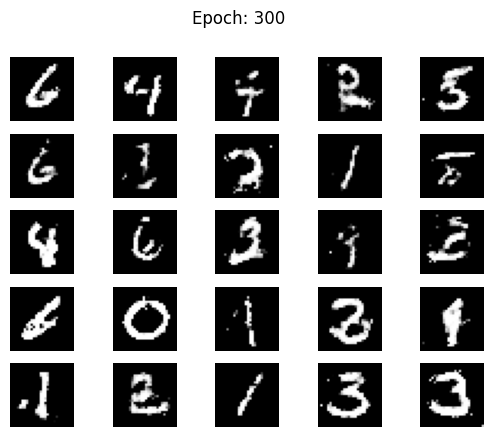

In [20]:
from matplotlib import pyplot
import matplotlib.image as mpimg
import imageio
def save_plot(examples, n,index, filenames):
    
    
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i], cmap=pyplot.get_cmap('gray'))
    #pyplot.show()
    pyplot.suptitle("Epoch: "+str(index))
    pyplot.savefig('./samples/gan_mnst_graph_'+str(index)+".png")
    filenames.append('./samples/gan_mnst_graph_'+str(index)+".png")

index=0
filenames=[]


for epoch in range(NUM_EPOCHS//10):
    images = []
    for ind in range(25):
        images.append( mpimg.imread('./images/sample_'+str(epoch*10)+'_e_'+str(ind+1) + '.png'))
    
    save_plot(images,5, epoch*10,filenames)
images=[]
for ind in range(25):
    images.append( mpimg.imread('./samples/sample_'+str(ind+1) + '.png'))
save_plot(images,5, 300,filenames)

In [23]:
import imageio
images = []

for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./movie.gif', images,duration=0.5)

/var/folders/fk/zgplf1nn05z6c5dv0bvz9cj00000gn/T/ipykernel_92112/2537806175.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


In [28]:
print(discriminator)

Discriminator(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [27]:
print(generator)

Generator(
  (layers): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
  )
)
